# インポートするもの

In [2]:
import pandas as pd
import numpy as np
import demoji
import MeCab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from sklearn.metrics import accuracy_score
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
import neologdn

path = 'C:/mecab-ipadic-neologd'#自分のneologd辞書があるpath

In [3]:
comdot = pd.read_csv('comdot.csv')
comdot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3249 entries, 0 to 3248
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   yuma     1476 non-null   object
 1   yamato   1332 non-null   object
 2   amugiri  3249 non-null   object
 3   hyuga    560 non-null    object
 4   yuta     686 non-null    object
dtypes: object(5)
memory usage: 127.0+ KB


# 前処理関数

In [4]:
#DataFrame渡したら前処理したものを返す
def memberTweet(df):
    try:
        df_member=pd.DataFrame(columns=['index','tweet','target'])
        for target,member in enumerate(df.columns):
            df_member_tweet = df[member].dropna()
            df_tweet = tweetClean(df_member_tweet,target)
            df_member = df_member.append(df_tweet)
        df_member = df_member.drop('index',axis=1).reset_index()
    except Exception as e:
        print(e)      
        
    return df_member

#tweetをきれいにする
def tweetClean(tweet_S,target):
    try:
        df = pd.DataFrame({'tweet':tweet_S,'target':target})
        df = df.query('not tweet.str.startswith("RT")',engine='python').reset_index()
        df['tweet'] = df['tweet'].replace(r"(https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+\$,%#]+)",
                                          "",regex=True) #URL
        df['tweet'] = df['tweet'].replace(r"\@[\w]+","",regex=True) #twitterID
        df['tweet'] = df['tweet'].str[:-13] #日付
        df['tweet'].astype(str)
        df['tweet'] = df['tweet'].apply(lambda x:neologdn.normalize(x))#カタカナを全角、数字を半角など
        df['tweet'] = df['tweet'].apply(demojitxt)#絵文字
        df['tweet'] = df['tweet'].replace(r"[0-9]+","0",regex=True)#数字半角
        df['tweet'] = df['tweet'].replace(r"[０-９]+","0",regex=True)#数字全角
        df['tweet'] = df['tweet'].apply(lambda x: leaving_space_between_words_column(x,path)) #分かち書き
        df['tweet'] = df['tweet'].str.replace('\n','')
        df['target'].astype(int)
    except Exception as e:
        print(e)
    return df

def demojitxt(txt):
    try:
        txt = demoji.replace(string=txt,repl="")
    except Exception as e:
        print(e)
        print(txt)
    return txt

def leaving_space_between_words_column(text,path):
    tagger = MeCab.Tagger('-d {path}'.format(path=path))
    splitted = ' '.join([x.split('\t')[0] for x in tagger.parse(text).splitlines()[:-1] 
                         if x.split('\t')[1].split(',')[0] not in ['助詞','助動詞', '接続詞', '記号']])
    return splitted

# モデル作成

In [ ]:
#mecabをインストールしてない人
#df = pd.read_csv('clean_comdot')
#df.info

In [5]:
df = memberTweet(comdot)
df.info()
sns.set_style('darkgrid')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   6392 non-null   int64 
 1   tweet   6392 non-null   object
 2   target  6392 non-null   object
dtypes: int64(1), object(2)
memory usage: 149.9+ KB


## アンダーサンプリングしてないモデル

In [22]:
target = [0,1,2,3,4]#0:yuma,1:yamato,2:amugiri,3:hyuga,4:yuta
X =df['tweet']
y = df['target'].astype(int)

In [129]:
y.value_counts()

2    3119
1    1053
0    1047
4     631
3     542
Name: target, dtype: int64

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=100
                                                 ,stratify=y)
model = make_pipeline(TfidfVectorizer(),MultinomialNB())
model.fit(X_train,y_train)
labels = model.predict(X_test)

Text(89.18, 0.5, 'predict label')

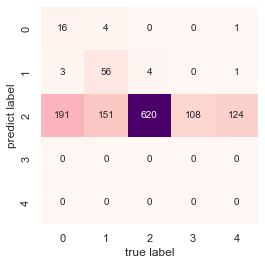

In [24]:
#アンダーサンプリングしてないモデル
mat = confusion_matrix(y_test,labels,labels=target)

sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
           xticklabels=target,yticklabels=target,cmap='RdPu')
plt.xlabel('true label')
plt.ylabel('predict label')

In [31]:
accuracy_score(labels,y_test)

0.5410476935105551

## アンダーサンプリングしたモデル

In [5]:
target = [0,1,2,3,4]#0:yuma,1:yamato,2:amugiri,3:hyuga,4:yuta
X =df['tweet']
y = df['target'].astype(int)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=100
                                                 ,stratify=y)

In [6]:
rank4 = y_train.value_counts()[4]
rank3 = y_train.value_counts()[3]

In [7]:
rus = RandomUnderSampler(sampling_strategy={0:rank4,1:rank4,2:rank4,3:rank3,4:rank4},random_state=10)

In [8]:
X_ut,y_ut = rus.fit_resample(X_train.values.reshape(-1,1),y_train)
X_uts = pd.Series(X_ut.reshape(-1))

In [9]:
model = make_pipeline(TfidfVectorizer(),MultinomialNB())
model.fit(X_uts,y_ut)
labels = model.predict(X_test)

Text(89.18, 0.5, 'predict label')

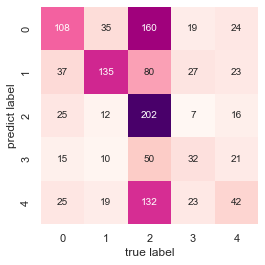

In [10]:
mat = confusion_matrix(y_test,labels,labels=target)

sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
           xticklabels=target,yticklabels=target,cmap='RdPu')
plt.xlabel('true label')
plt.ylabel('predict label')

In [11]:
accuracy_score(labels,y_test)

0.40578577013291633

# 考察

In [100]:
for num,mem in enumerate(comdot.columns):
    s = len(comdot[['{mem}'.format(mem=mem)]].dropna().query("{mem}.str.startswith('@')".format(mem=mem)
                                                      ,engine='python'))
    t = df['target'].value_counts()[num]
    y = s / t 
    print('{mem}のリプライ数：'.format(mem=mem),s)
    print('{mem}の総ツイート数：'.format(mem=mem),t)
    print('{mem}のrep/tweet：'.format(mem=mem),y)

yumaのリプライ数： 481
yumaの総ツイート数： 1047
yumaのrep/tweet： 0.4594078319006686
yamatoのリプライ数： 385
yamatoの総ツイート数： 1053
yamatoのrep/tweet： 0.36562203228869894
amugiriのリプライ数： 2366
amugiriの総ツイート数： 3119
amugiriのrep/tweet： 0.7585764668162873
hyugaのリプライ数： 232
hyugaの総ツイート数： 542
hyugaのrep/tweet： 0.4280442804428044
yutaのリプライ数： 383
yutaの総ツイート数： 631
yutaのrep/tweet： 0.606973058637084


・アンダーサンプリングしたモデルはしてないモデルに比べて正解率は低いが混同行列を比較して見てみるとアンダーサンプリングしたモデルのほうが上手く特徴を捉えられていることがわかる。
・上のセルを見るとamugiriのリプライ割合は75%でおそらくファンに対して似たようなリプライを返しているため特徴がつかみにくく予測も分散したと考えられる。
・yumaとyamatoの特徴はうまく捉えることができているように見える。
・hyugaとyutaのリプライ割合は42%と60%でありamugiriより低いが総ツイート数は542と631で少ないため,特徴を捉えられずうまく分類できてないように考えられる。

# 実際にモデルに分類させる

In [64]:
#どれぐらいの割合でどのメンバーか表示する関数
def predict_comdot(ds,model=model):
    comdot_member = {0:'yuma',1:'yamato',2:'amugiri',3:'hyuga',4:'yuta'}
    pred = model.predict(ds)
    uni,counts =  np.unique(pred,return_counts=True)
    print('あなたのツイート数：',len(pred))
    for u,count in zip(uni,counts):
        print(comdot_member[u] ,':', count)
    parcent = counts.max()/len(pred)
    member = comdot_member[uni[counts.tolist().index(counts.max())]]
    print('あなたはのツイートは{par:.2%}ぐらいで{member}です'.format(par=parcent,member=member))
    return uni,counts

In [7]:
yaci = pd.read_csv('yaci.csv')
yaci = yaci['yaci']
yaci = tweetClean(yaci,0)
yaci['tweet']

0                                              強く なる 頑張る
1                   配信 やっ てる 元気 出る なんで なん 終わる 涙 止まら なる の
2      だめ まだ ち 弱い 泣い しまう 涙 軽い もの 気 する こと ない しれ 気持ち まと...
3      貴様 送る もう ここ 見 くれ 君 心残り 感じ させる ため 書い てる わけ 前 向く...
4                            彼 幸せ なっ くれ 言っ ただ ち 幸せ なら いけ
                             ...                        
201                ありがとう ちの 人生観 見 い人 見れる よう し こっち こっち 動く
202                        憧れる の 自分 最大限 尽くせ それ ちの 考える 本気
203                             なら ち 一人 多く 人 支え られる 人 なら
204    こうたん みたい 編集 うまく なり 暇人 みたい 配信 面白く し ドク みたい 急 面白...
205            臭い 発言 多い 言わ れ こっち これから 書く み たい人 見れる よう する
Name: tweet, Length: 206, dtype: object

In [29]:
comdot_member = {0:'yuma',1:'yamato',2:'amugiri',3:'hyuga',4:'yuta'}
pred = model.predict(yaci['tweet'])

In [65]:
uni,counts = predict_comdot(yaci['tweet'])

あなたのツイート数： 206
yuma : 27
yamato : 122
amugiri : 20
hyuga : 17
yuta : 20
あなたはのツイートは59.22%ぐらいでyamatoです


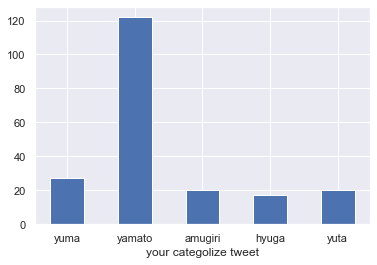

In [76]:
#可視化
plt.bar([comdot_member[u] for u in uni],counts,width=0.5)
plt.xlabel('your categolize tweet')
plt.show()
